# Self-Driving Car Engineer Nanodegree


## Project: Build a Traffic Sign Recognition Classifier for German Traffic Signs 

I've built and trained a deep neural network to classify German traffic signs using Tensorflow. 

## Step 0: Load The Data

In [71]:
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.contrib.layers import flatten
import tensorflow as tf
import numpy as np 
import cv2
import collections
import pandas as pd
import glob

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Basic Summary of the Data Set 

In [72]:
n_train = len(X_train)

n_validation = len(X_valid)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

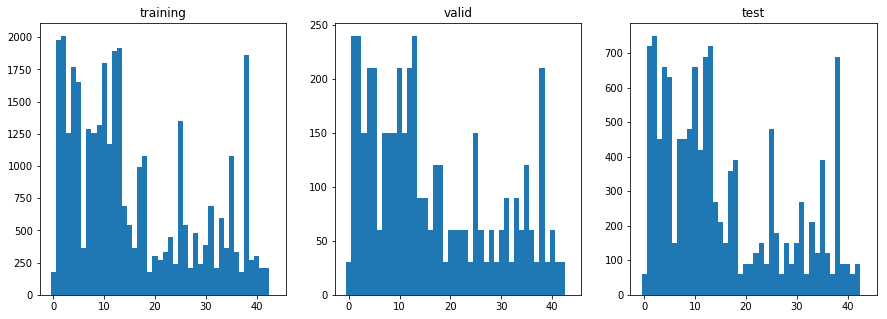

In [73]:
%matplotlib inline

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(y_train, np.arange(-0.5, n_classes+1.1))
ax[0].set_title("training")

ax[1].hist(y_valid, np.arange(-0.5, n_classes+1.1))
ax[1].set_title("valid")

ax[2].hist(y_test, np.arange(-0.5, n_classes+1.1))
ax[2].set_title("test")

plt.show()

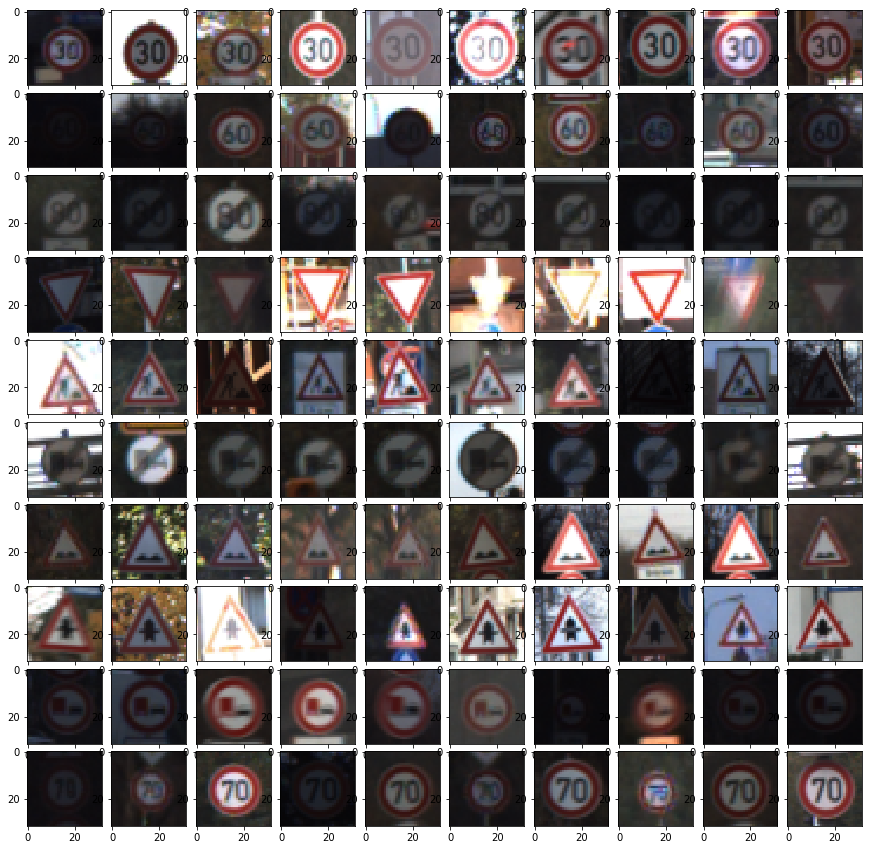

In [4]:
# Visualization of training data 
# Plots 10 random images coresponding to each label in the german training dataset 
def plot_sample_images_for_labels(X, Y, labels):
    indices_to_plot = []
    for each_label in labels:
        indices = [i for i,x in enumerate(Y) if x == each_label]
        random.shuffle(indices)
        indices_to_plot.extend(indices[:10]) 

    plt.figure(figsize = (15,15))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.1, hspace=0.1)

    i=0
    for g in gs:
        ax = plt.subplot(g)
        plt.imshow(X[indices_to_plot[i]].squeeze())
        i = i + 1

    plt.show()

# 10 random labels to be visualized 
plot_sample_images_for_labels(X_train, y_train, [1, 3, 6, 13, 25, 42, 22, 11, 10, 4])

## Step 2: Generate Fake Data 

The distribution of images in the training set is not balanced. To balance the distribution, fake images are generated from the original image by applying the following transformation: scaling, traslation and rotation. 

A balanced training dataset will prevent overfitting and improve the accuracy of prediction. 

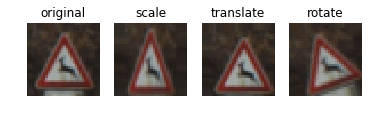

In [5]:
# geometric transformations
def original(img) : return img

# scaling
def scale(img, x_scale=0.8, y_scale=1.2) :
    r,c = img.shape[:-1]
    scaled_img = cv2.resize(img,None,fx=x_scale,fy=y_scale)
    new_img = cv2.copyMakeBorder(scaled_img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]
    
# translation
def translate(img, d_x=2, d_y=-2):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2)+d_y, round((cols-c)/2)-d_x
    return new_img[r0:r0+r, c0:c0+c]

# rotation
def rotate(img, theta=20):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    rotate_angle = theta
    M = cv2.getRotationMatrix2D((cols/2,rows/2),rotate_angle,1)
    new_img = cv2.warpAffine(new_img,M,(cols,rows))
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

# plot transformation operation for a sample image 
fig, ax = plt.subplots(1,4, figsize=(6,2))
for i,transform in enumerate([original, scale, translate, rotate]) :
    ax[i].imshow(transform(X_train[888]).squeeze())
    ax[i].axis('off')
    ax[i].set_title(transform.__name__)

In [6]:
random_scale = lambda img : scale(img, x_scale=random.uniform(0.85,1.1), y_scale=random.uniform(0.85,1.1))
random_translate = lambda img : translate(img, d_x=random.randint(-2,2), d_y=random.randint(-2,2))
random_rotate = lambda img : rotate(img, theta=random.uniform(-20.,20.))

def random_transform(img) :
    new_img = img
    transform_list = [random_scale, random_translate, random_rotate]
    random.shuffle(transform_list)
    for transform in transform_list :
        new_img = transform(new_img)
    return new_img

def augment_data(X_data, y_data, n):
    """
    n is the total number of examples to be generated 
    """
    X_data_fake, y_data_fake = [],[]
    for label in range(n_classes):
        indices = [i for i,x in enumerate(y_data) if x == label]
        n_fake = n - len(indices)
        if n_fake <=0 : continue
        for i in range(n_fake):
            image_index = random.choice(indices)
            image = X_data[image_index]
            X_data_fake.append(random_transform(image))
            y_data_fake.append(label)
    return np.array(X_data_fake),np.array(y_data_fake)

# generating 3000 images for all labels to balance the dataset 
X_fake, y_fake = augment_data(X_train, y_train, 3000)

X_train = np.concatenate((X_train, X_fake))
y_train = np.concatenate((y_train, y_fake))


----

## Step 2: Design and Test a Model Architecture


### LENET 

The model used for classifiction is [Lenet-5](http://yann.lecun.com/exdb/lenet/). It is a convolutional neural network designed to recognize visual patterns directly images with minimal preprocessing. It was originally designed for recognizing hand-written characters.


### Pre-process the DataSet 

The images are converted to gray scale i.e single Y channel using Luma Coding and then normalized. Based on findings mentioned in [this paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), using color channel did not improve the accuracy by much. 

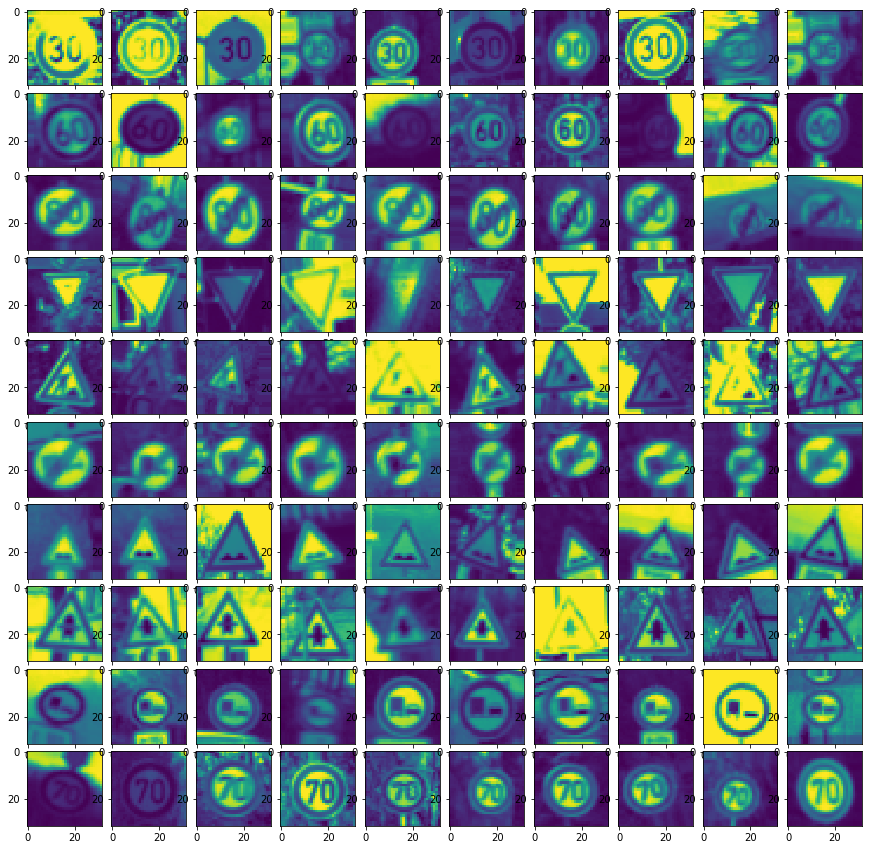

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def pre_process_data(data):
    
    # convert to grayscale (single y channel) using Luma Coding https://en.wikipedia.org/wiki/Grayscale
    data = 0.299 * data[:, :, :, 0] + 0.587 * data[:, :, :, 1] + 0.114 * data[:, :, :, 2]
    
    # normalize data to scale to [0,1]
    data = (data/225.).astype(np.float32)                                                             
   
    # re-shape to add the 32x32x1
    data = data.reshape(data.shape + (1,)) 
    return data 
    
    
X_train = pre_process_data(X_train)
X_valid = pre_process_data(X_valid)
X_test  = pre_process_data(X_test)

plot_sample_images_for_labels(X_train, y_train, [1, 3, 6, 13, 25, 42, 22, 11, 10, 4])

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.
`keep_prob` is a placeholder for applying dropout 

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

EPOCHS = 15
BATCH_SIZE = 128

## Model Architecture


**Layer 1**: Convolutional. The output shape should be 28x28x6.

**Activation**. Your choice of activation function.

**Pooling**. The output shape should be 14x14x6.

**Dropout**. 10% of the input is dropped out.  

**Layer 2**: Convolutional. The output shape should be 10x10x16.

**Activation**. Your choice of activation function.

**Pooling**. The output shape should be 5x5x16.

**Dropout**. 20% of the input is dropped out.  

**Flatten**. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

**Layer 3**: Fully Connected. This should have 120 outputs.

**Activation**. Your choice of activation function.

**Dropout**. 30% of the input is dropped out.  

**Layer 4**: Fully Connected. This should have 84 outputs.

**Activation**. Your choice of activation function.

**Dropout**. 40% of the input is dropped out.  

**Layer 5**: Fully Connected (Logits). This should have 43 outputs.

In [9]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob[0])
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob[1])
    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob[2])

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob[3])

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (logits, conv1, conv2, fc1, fc2)

## Training Pipeline

In [10]:
rate = 0.001

logits, conv1, conv2, fc1, fc2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation 

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: np.array([1.0, 1.0, 1.0, 1.0])})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [12]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: np.array([0.9, 0.8, 0.7, 0.6])})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.763

EPOCH 2 ...
Validation Accuracy = 0.859

EPOCH 3 ...
Validation Accuracy = 0.905

EPOCH 4 ...
Validation Accuracy = 0.920

EPOCH 5 ...
Validation Accuracy = 0.926

EPOCH 6 ...
Validation Accuracy = 0.937

EPOCH 7 ...
Validation Accuracy = 0.945

EPOCH 8 ...
Validation Accuracy = 0.946

EPOCH 9 ...
Validation Accuracy = 0.952

EPOCH 10 ...
Validation Accuracy = 0.944

EPOCH 11 ...
Validation Accuracy = 0.949

EPOCH 12 ...
Validation Accuracy = 0.950

EPOCH 13 ...
Validation Accuracy = 0.946

EPOCH 14 ...
Validation Accuracy = 0.954

EPOCH 15 ...
Validation Accuracy = 0.963

Model saved


## Test the Model 

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.948



## Step 3: Test a Model on New Images

8 images captured from the streets of Berlin using Google Street view was used for testing and getting more insights into the working of the model. 

 `signnames.csv` contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

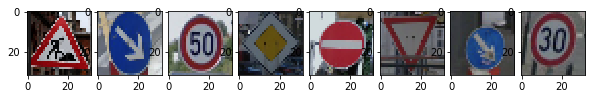

In [64]:
### Load the images and plot them here.

# read sign name from csv
def get_sign_names():
    return pd.read_csv('./signnames.csv').values

# plot the test images 
def draw_test_images(images): 
    plt.figure(figsize = (10,10))
    gs = gridspec.GridSpec(1 , 8)
    gs.update(wspace=0.1, hspace=0.1)
    
    i=0
    for g in gs:
        ax = plt.subplot(g)
        plt.imshow(images[i].squeeze())
        i = i + 1

    plt.show()

img_files = glob.glob('test-images/*.png')
sign_names = get_sign_names()
web_signs = []
web_labels = []

for file in img_files:
    # get label from file, first 2 digits of filename
    label = int(file.split('/')[-1][:2])
    web_labels.append(label)
    img =  cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (32, 32)) 
    web_signs.append(resized_image)
    
draw_test_images(web_signs)

# pre-process test images 
web_signs_processed = pre_process_data(np.array(web_signs))
web_labels = np.array(web_labels)

### Predict the Sign Type for Each Image

In [65]:
# run the new images through the trained model and evaluate the accuracy 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(web_signs_processed, web_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.889


### Analyze Performance

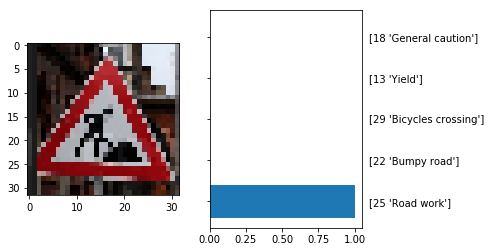

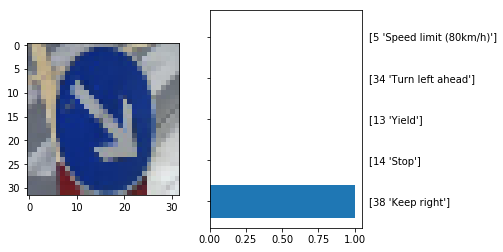

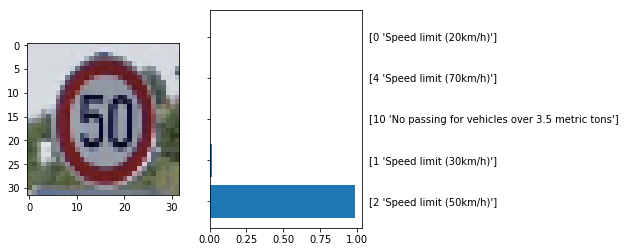

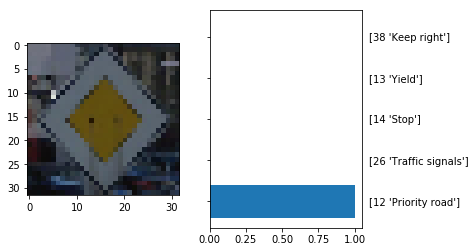

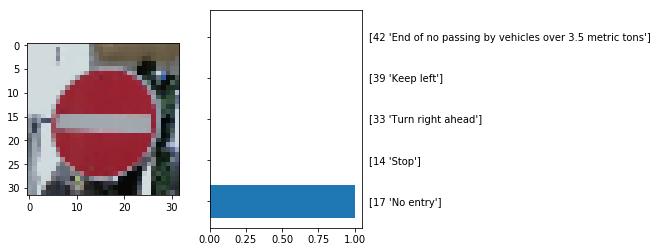

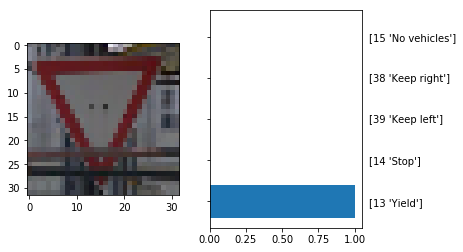

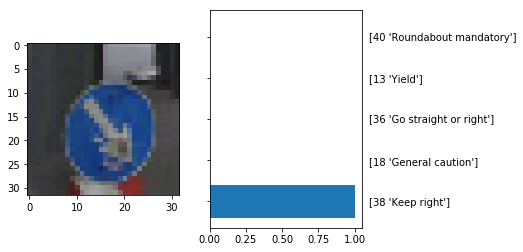

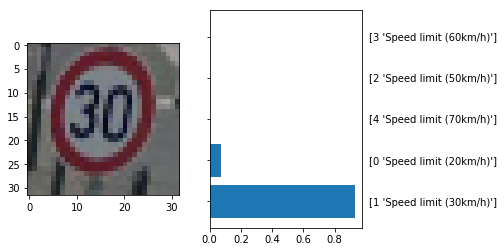

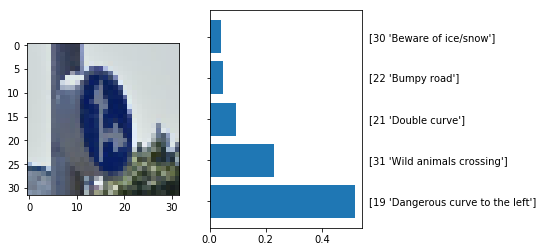

In [66]:
### Calculates the accuracy for these 8 new images. 

# top k predictions for each image.
TOP_K = 5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=TOP_K), feed_dict={x:web_signs_processed, keep_prob: np.array([0.9, 0.8, 0.7, 0.6]) })

for i in range(len(web_signs)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(web_signs[i])
    ax2.barh(range(TOP_K), top.values[i])
    ax2.set_yticks(range(TOP_K))
    ax2.set_yticklabels( sign_names[top[1][i].astype(int)])
    ax2.tick_params(labelleft='off' , labelright='on')

### Top 5 Softmax Probabilities For Each Image Found on the Web

For each new image, the model's softmax probabilities is printed out thatshows the **certainty** of the model's predictions.

In [74]:
for i in range(len(img_files)):
    print("Image ", img_files[i])
    print("Probabilities ", ["{0:0.3f}".format(i) for i in top[0][i]])
    print("Indices ", top[1][i])
    print("Sign Names ", sign_names[top[1][i].astype(int)])
    print("")
    

Image  test-images/25_road_work.png
Probabilities  ['1.000', '0.000', '0.000', '0.000', '0.000']
Indices  [25 22 29 13 18]
Sign Names  [[25 'Road work']
 [22 'Bumpy road']
 [29 'Bicycles crossing']
 [13 'Yield']
 [18 'General caution']]

Image  test-images/38_keep_right.png
Probabilities  ['1.000', '0.000', '0.000', '0.000', '0.000']
Indices  [38 14 13 34  5]
Sign Names  [[38 'Keep right']
 [14 'Stop']
 [13 'Yield']
 [34 'Turn left ahead']
 [5 'Speed limit (80km/h)']]

Image  test-images/02_50km.png
Probabilities  ['0.983', '0.017', '0.000', '0.000', '0.000']
Indices  [ 2  1 10  4  0]
Sign Names  [[2 'Speed limit (50km/h)']
 [1 'Speed limit (30km/h)']
 [10 'No passing for vehicles over 3.5 metric tons']
 [4 'Speed limit (70km/h)']
 [0 'Speed limit (20km/h)']]

Image  test-images/12_priority_road.png
Probabilities  ['1.000', '0.000', '0.000', '0.000', '0.000']
Indices  [12 26 14 13 38]
Sign Names  [[12 'Priority road']
 [26 'Traffic signals']
 [14 'Stop']
 [13 'Yield']
 [38 'Keep right'

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [75]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: np.array([1.0, 1.0, 1.0, 1.0])})
    featuremaps = activation.shape[3]
    print(range(featuremaps))
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

conv1 : First layer
range(0, 6)


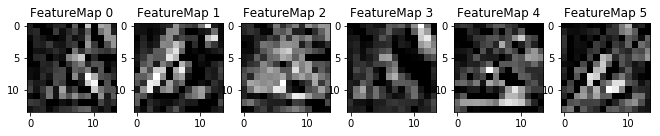

In [76]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("conv1 : First layer")
    outputFeatureMap(web_signs_processed, conv1)

conv2 : Second layer
range(0, 16)


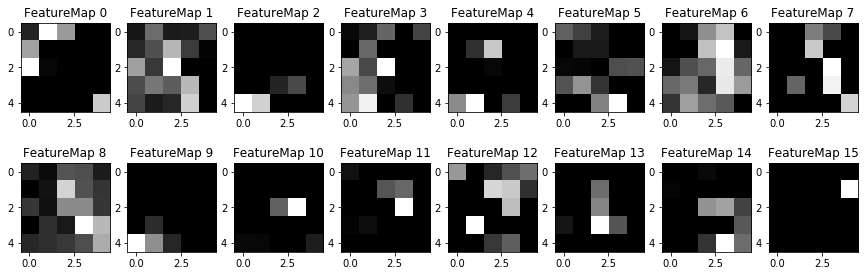

In [70]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("conv2 : Second layer")
    outputFeatureMap(web_signs_processed, conv2)